In [1]:
import pandas as pd
% load_ext autoreload
% autoreload 2

In [40]:
import torch
from models import pretrained
from models.classifier import TorchvisionClassifier
from data.cifar10 import CIFAR10DataModule, MEAN, STD
from data.uci_heart import UCIHeartModule
from data.camelyon import CamelyonModule
from glob import glob
from tqdm import tqdm
from rejectron.rejectronmodule import RejectronModule
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.transforms import Normalize
from utils.image_transforms import UnNormalize
from PIL import Image
import numpy as np

torch.set_grad_enabled(False)

In [97]:
dm = CIFAR10DataModule(batch_size=50, shift=True, test_seed=0, test_samples=50,
                       negative_labels=False, return_meta=True)

In [44]:
def get_test_loader(seed, shift, samples):
    return CIFAR10DataModule(batch_size=50, shift=shift, test_seed=seed, test_samples=samples,
                             negative_labels=False, return_meta=True).test_dataloader()


def model(seed, shift, samples, dataset):
    rm = RejectronModule(h)
    rm.load_from_directory(
        f'/voyager/projects/tomginsberg/detectron/checkpoints/{dataset}/detectron/ckp/{seed=}_{samples=}_{shift=}',
        sub_dirs=True)
    return rm


def get_batch(dl):
    return next(iter(dl))

In [105]:
h = pretrained.resnet18_trained_on_cifar10().eval()

In [ ]:
data = []
logits = []
for seed in tqdm(range(10)):
    x, meta = get_batch(get_test_loader(seed=seed, shift=True, samples=50))
    rm = model(seed=seed, shift=True, samples=50, dataset='cifar')
    log = rm.logits(x)
    data.append(x)
    logits.append(log)
# yhat = rm(x)
# probs = logits.softmax(dim=2)
# entr = rm.entropy(x)

In [75]:
def f(r):
    idx = torch.where(r)[0]
    if len(idx) == 0:
        return 0
    return idx[0]

In [122]:
mask = []
for i, lg in enumerate(logits):
    pr = lg.argmax(dim=2)
    rej = (~(pr == pr[:, 0][:, None])).T
    mask.append(torch.tensor([f(r) for r in rej]))
mask = torch.cat(mask)

In [123]:
data = torch.cat(data)

In [124]:
data_ = torch.stack([dm.un_normalize(x) for x in data])

In [60]:
def pil_img_row(imgs):
    return Image.fromarray(
        np.concatenate([(img.permute(1, 2, 0) * 255).numpy().astype(np.uint8) for img in imgs], axis=1))

In [132]:
pil_img_row(data_[mask == 7])

ValueError: need at least one array to concatenate

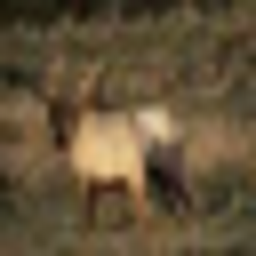

In [104]:
pil_img_row([dm.un_normalize(dm.train[3][0])]).resize((256, 256))

In [60]:
def brier_score(yhat, y):
    y = F.one_hot(y, num_classes=10)
    return torch.mean(torch.abs(yhat - y) ** 2, -1)

In [81]:
(logits.argmax(dim=-1).T == logits.argmax(dim=-1)[0, :, None]).int().tolist()

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1],
 [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
 [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0],
 [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0],
 [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
 [1, 0, 1, 1, 1, 0, 0, 1, 1,

In [85]:
clus = [[0, 1, 2, 7, 9, 10, 11, 12, 18, 20, 21, 22, 23, 25, 29, 31, 32, 34, 35, 38, 39, 41, 42, 43, 44, 47, 48, 49],
        [6, 8, 24, 26, 27, 28, 33, 37, 45], [3, 4, 15, 16, 17, 19, 30, 40], [5, 13, 36, 46], [14]]

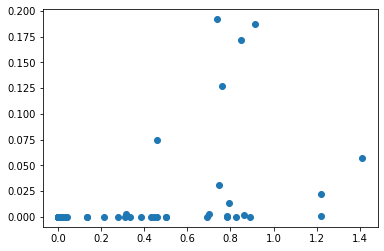

In [62]:
plt.scatter(entr, brier_score(probs[0, :], meta[0]));

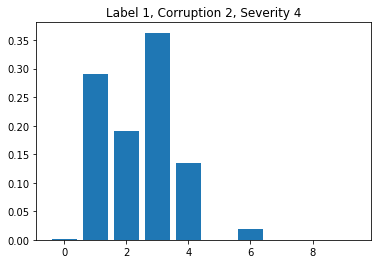

In [51]:
idx = 4
label, sev, corr = meta[0][idx], meta[1][idx], meta[2][idx]
plt.bar(x=range(10), height=probs[1:, idx].mean(0))
plt.title(f'Label {label}, Corruption {corr}, Severity {sev}');

In [99]:
from PIL import Image
import numpy as np

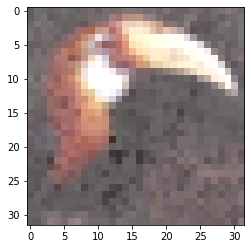

In [114]:
plt.imshow(dm.un_normalize(x[3]).permute(1, 2, 0).numpy())

In [118]:
ims = [[Image.fromarray((dm.un_normalize(xx).permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        for xx in x[c]] for c in clus]

In [116]:
def image_grid(ims: list[Image], ncols=5):
    nrows = int(len(ims) / ncols) + 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    for i, ax in enumerate(axes.flat):
        if i < len(ims):
            ax.imshow(ims[i])
            ax.axis('off')
        else:
            ax.axis('off')
    return fig, axes

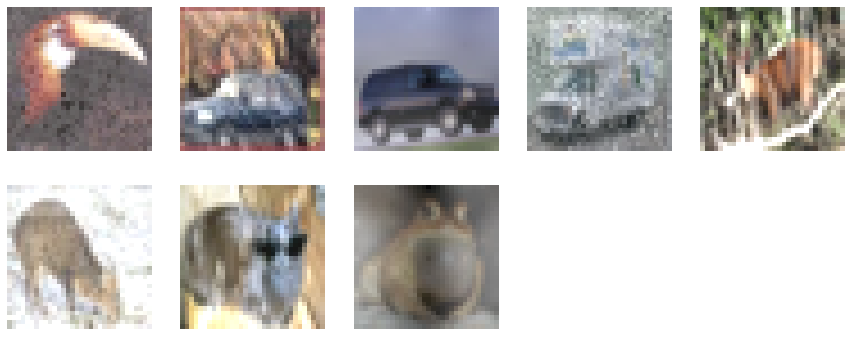

In [121]:
fig, axes = image_grid(ims[2])
plt.show()

In [ ]:
dataset = 'camelyon'
data = {}
for shift in [True, False]:
    for samples in [10, 20, 50]:
        for seed in range(10):
            rm = model(seed=seed, shift=shift, samples=samples, dataset=dataset)
            dl = get_test_loader(seed=seed, shift=shift, samples=samples)
            x, y = get_batch(dl)
            data[(shift, samples, seed)] = rm.entropy(x)

In [12]:
torch.save(data, f'../checkpoints/{dataset}/entropy.pt')

In [3]:
dataset = 'cifar'

In [4]:
data = torch.load(f'../checkpoints/{dataset}/entropy.pt')

In [17]:
en_q = torch.cat([data[(True, 20, i)] for i in range(10)])
en_p = torch.cat([data[(False, 20, i)] for i in range(10)])

<AxesSubplot:ylabel='Count'>

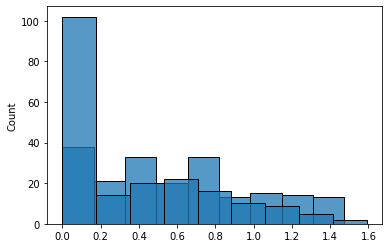

In [18]:
sns.histplot(en_q.numpy(), label='Q')
sns.histplot(en_p.numpy(), label='P')

In [9]:
from scipy.stats import ks_2samp

In [36]:

res = []
for samples in [10, 20, 50]:
    s = []
    for i in range(10):
        true = data[(True, samples, i)]
        for j in range(10):
            all_false = torch.cat([data[(False, samples, k)] for k in range(10) if k != j])
            s.append(ks_2samp(true, all_false).pvalue)

    n = []
    for i in range(10):
        true = data[(False, samples, i)]
        for j in range(10):
            all_false = torch.cat([data[(False, samples, k)] for k in range(10) if (k != j) and (k != i)])
            n.append(ks_2samp(true, all_false).pvalue)

    res.append(dict(shift=False, samples=samples, pvals=n))
    res.append(dict(shift=True, samples=samples, pvals=s))
res = pd.DataFrame(res)

In [37]:
res

,shift,samples,pvals
0,False,10,"[0.8636882339578191, 0.7019594859953062, 0.575..."
1,True,10,"[0.9656301014711982, 0.8636882339578191, 0.761..."
2,False,20,"[0.9662814887736348, 0.979089653231994, 0.9888..."
3,True,20,"[0.30079041916934146, 0.32928199479783016, 0.3..."
4,False,50,"[0.7541469266129666, 0.7644313163674425, 0.737..."
5,True,50,"[0.03182896257907808, 0.0346984139019797, 0.04..."


In [43]:
res = []
for shift in [True, False]:
    for samples in [10, 20, 50]:
        res.append(dict(shift=shift, samples=samples, pvals=[]))
        for i in range(10):
            for j in range(10):
                if i == j and not shift:
                    continue
                s = data[(shift, samples, i)].numpy()
                n = data[(False, samples, j)].numpy()
                pv = ks_2samp(s, n).pvalue
                res[-1]['pvals'].append(pv)

res = pd.DataFrame(res)

In [44]:
# dataset = 'camelyon'
res.to_json(f'../checkpoints/{dataset}/entropy.json')

In [33]:
res = pd.read_json(f'../checkpoints/{dataset}/entropy.json')

In [ ]:
sns.kdeplot(res.query('samples == 50 and shift == True').iloc[0]['pvals'], label='shift=True')
sns.kdeplot(res.query('samples == 50 and shift == False').iloc[0]['pvals'], label='No shift')
plt.xlabel('Entropy (over 50 samples)')

In [19]:
import pickle
import numpy as np

In [20]:
def load_preds(seed, samples, shift, method='detectron'):
    if method == 'detectron':
        method = 'detectron2'
    f = f'../checkpoints/uci/{method}/preds_{seed=}_{samples=}_{shift=}.pkl'
    return pickle.load(open(f, 'rb'))

In [36]:
def numpy_entropy(x):
    # softmax
    eps = 1e-8
    x = np.stack(x).mean(0)
    return -(x * np.log(x + eps) + (1 - x) * np.log(1 - x + eps))


def entropy(samples, hypothesis=True, method='detectron'):
    vals = []
    for i in range(2):
        vals.append(numpy_entropy((load_preds(i, samples, hypothesis, method=method))))
    return np.stack(vals)

In [25]:
data = []
for n in range(10, 101, 10):
    sh = entropy(n, False)
    n_sh = entropy(n, True)

    for q, p in zip(sh, n_sh):
        data.append(dict(n=n, p_entropy=p.mean(), q_entropy=q.mean()))

data = pd.DataFrame(data)

In [38]:
models = pretrained.mlp_collection_trained_on_uci_heart(device='cpu')

/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [48]:
from shift_detection.shiftdetection import ensemble_entropy

In [58]:
entropies = []
for s in [10, 20, 50]:
    dm = UCIHeartModule(test_samples=10, shift=True, batch_size=512)
    x, _ = get_batch(dm.test_dataloader(specific_test_loader='ood'))
    q_en_ensemble = ensemble_entropy(torch.stack([m(x) for m in models]))

    dm = UCIHeartModule(test_samples='all', shift=False, batch_size=512)
    x, _ = get_batch(dm.test_dataloader(specific_test_loader='iid'))
    p_en_ensemble = ensemble_entropy(torch.stack([m(x) for m in models]))
    entropies.append([p_en_ensemble, q_en_ensemble])

<AxesSubplot:ylabel='Density'>

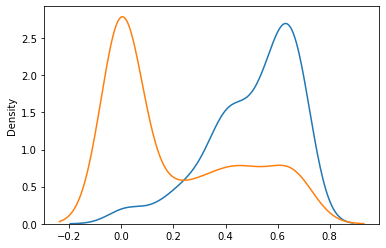

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for s, ax in zip([10, 20, 50], axs.ravel()):
    sns.kdeplot(p_en_ensemble, label='No shift', ax=ax)
    sns.kdeplot(q_en_ensemble, label='Shift', ax=ax)
    ax.set_title(f'{s} samples')
    ax.set_xlim(.4, .8)


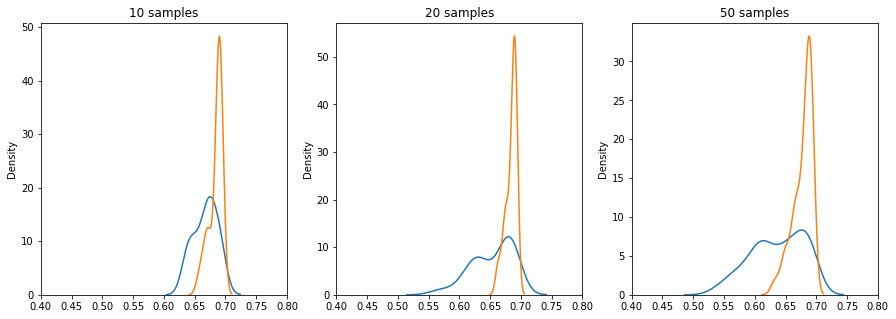

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for s, ax in zip([10, 20, 50], axs.ravel()):
    sns.kdeplot(entropy(s, False).flatten(), ax=ax)
    sns.kdeplot(entropy(s, True).flatten(), ax=ax)
    ax.set_title(f'{s} samples')
    ax.set_xlim(.4, .8)

In [60]:
def get_exp(samples, shift, dataset='cifar', method='detectron'):
    # there is a bit of technical debt cleanup here :(
    r = []
    if method == 'detectron' and dataset == 'uci':
        method = 'detectron2'
    if method == 'detectron' and dataset == 'camelyon' and samples < 50:
        method = 'detectron/res'
    if method == 'domain':
        if dataset == 'uci':
            f = f'/voyager/projects/tomginsberg/detectron/checkpoints/{dataset}/{method}/*samples={samples}_shift={shift}.csv'
        else:
            f = f'/voyager/projects/tomginsberg/detectron/checkpoints/{dataset}/{method}/samples={samples}*_shift={shift}.csv'
    else:
        f = f'/voyager/projects/tomginsberg/detectron/checkpoints/{dataset}/{method}/*samples={samples}_shift={shift}.csv'
    return pd.concat([pd.read_csv(file) for file in glob(f)]).reset_index(drop=True)

In [118]:
dataset = 'camelyon'
rng = [10, 20, 50]
data = pd.concat([get_exp(i, True, dataset=dataset) for i in rng]).reset_index(drop=True)
data_fls = pd.concat([get_exp(i, False, dataset=dataset) for i in rng]).reset_index(drop=True)

In [114]:
data_fls.test_acc

0      0.7
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
313    1.0
314    1.0
315    1.0
316    1.0
317    1.0
Name: test_acc, Length: 318, dtype: float64

<AxesSubplot:xlabel='Step', ylabel='test_reject'>

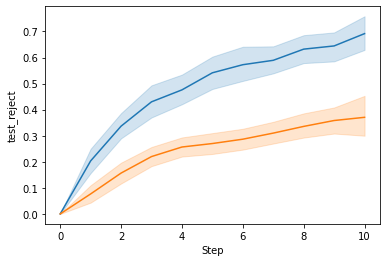

In [119]:
sns.lineplot(x='Step', y='test_reject', data=data.round(1))
sns.lineplot(x='Step', y='test_reject', data=data_fls.round(1))

<AxesSubplot:xlabel='Step', ylabel='test_acc'>

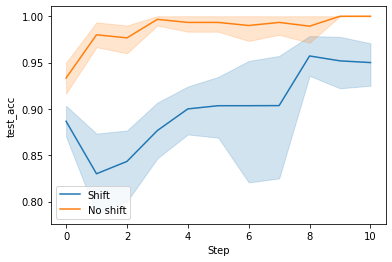

In [121]:
sns.lineplot(x='Step', y='test_acc', data=data.round(1), label='Shift')
sns.lineplot(x='Step', y='test_acc', data=data_fls.round(1), label='No shift')